#Problem 1



In [ ]:
import numpy as np
import pandas as pd
from keras.datasets import mnist

# Change the training dataset so that it has more training examples and more input variables.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Change the non-linearity of the hidden layer to ReLU
def nonlin(x,deriv=False):
  if(deriv==True):
    gradient = np.zeros(x.shape)
    gradient[x >= 0]=1
    return gradient
  elif(deriv==False):
    x[x < 0] = 0
    return x

# Change the learning rate of gradient descent
lr = 0.0000001

X = x_train.reshape(len(y_train),28*28)
X = X/255
y = y_train.reshape(len(y_train),1)

syn0 = np.random.uniform(-1,1,(28*28,10))
syn1 = np.random.uniform(-1,1,(10,1))

In [ ]:
for j in range(6000):

    l0 = X
    l1 = nonlin(np.dot(l0,syn0))
    l2 = nonlin(np.dot(l1,syn1))
    l2_error = 0.5*(y - l2)**2
    
    if (j% 1000) == 0:
        print("Error:" + str(np.mean(l2_error)))
    
    l2_delta = -(y - l2)*nonlin(np.dot(l1,syn1),deriv=True)
    l1_error = l2_delta.dot(syn1.T)
    l1_delta = l1_error * nonlin(np.dot(l0,syn0),deriv=True)

    syn1 -= lr * l1.T.dot(l2_delta)
    syn0 -= lr * l0.T.dot(l1_delta)


Error:14.06951426579194
Error:2.5040274095397073
Error:2.1857894805894693
Error:2.005663821418174
Error:1.8784565647413394
Error:1.7847638633542269


# Problem 2



In [ ]:
import numpy as np
from IPython.display import Image

NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 20, "activation": "relu"},
    {"input_dim": 20, "output_dim": 40, "activation": "relu"},
    {"input_dim": 40, "output_dim": 60, "activation": "relu"},
    {"input_dim": 60, "output_dim": 40, "activation": "relu"},
    {"input_dim": 40, "output_dim": 20, "activation": "relu"},
    {"input_dim": 20, "output_dim": 1, "activation": "sigmoid"}
]

def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr

def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

def train(X, Y, nn_architecture, epochs, learning_rate, verbose=False, callback=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        # step forward
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            #if(callback is not None):
            #    callback(i, params_values)
            
    return params_values

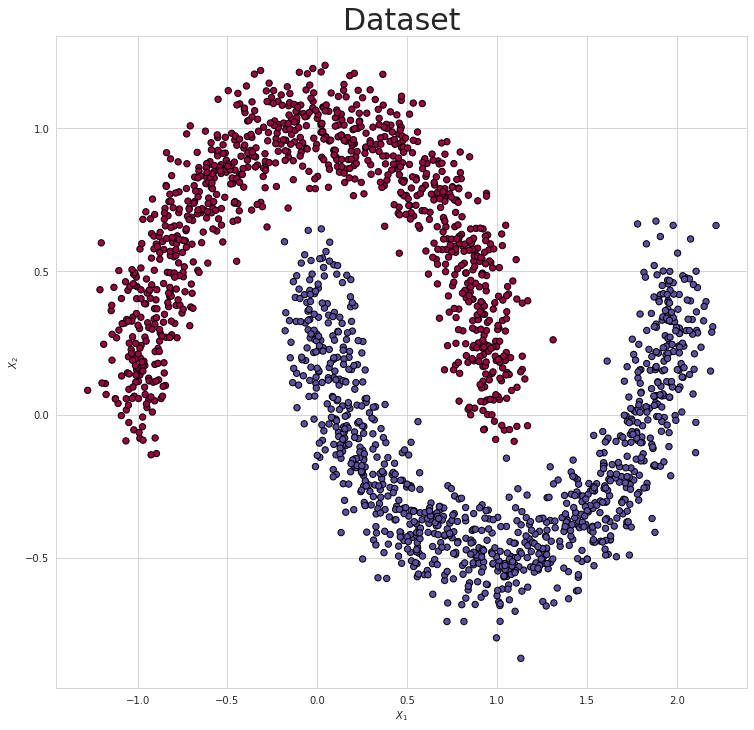

In [ ]:
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import regularizers

from sklearn.metrics import accuracy_score

# number of samples in the data set
N_SAMPLES = 2000
# ratio between training and test sets
TEST_SIZE = 0.1

X, y = make_moons(n_samples = N_SAMPLES, noise=0.1, random_state=150)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=150)

# the function making up the graph of a dataset
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    #if(file_name):
        #plt.savefig(file_name)
        #plt.close()

make_plot(X, y, "Dataset")

In [ ]:
# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.05)

# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

# Accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f} - David".format(acc_test))

Test set accuracy: 1.00 - David


In [ ]:
# Building a model
model = Sequential()
model.add(Dense(20, input_dim=2,activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train, epochs=200, verbose=0)

Y_test_hat = model.predict_classes(X_test)
acc_test = accuracy_score(y_test, Y_test_hat)
print("Test set accuracy: {:.2f} - Goliath".format(acc_test))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Test set accuracy: 1.00 - Goliath


Instructions for updating:
Please use `model.predict()` instead.


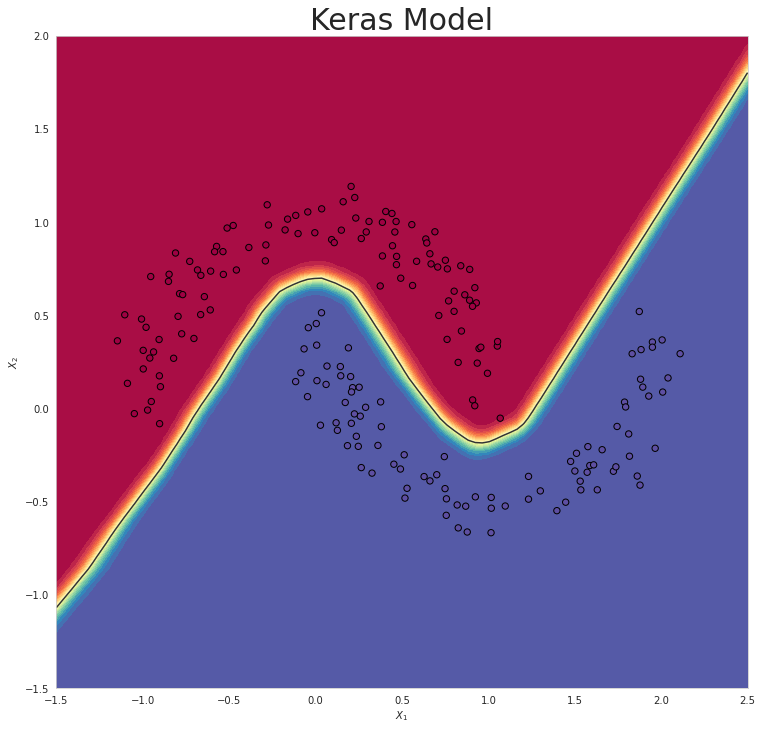

In [ ]:
# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
# output directory (the folder must be created on the drive)
OUTPUT_DIR = "./binary_classification_vizualizations/"

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

def callback_keras_plot(epoch, logs):
    plot_title = "Keras Model - It: {:05}".format(epoch)
    file_name = "keras_model_{:05}.png".format(epoch)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    prediction_probs = model.predict_proba(grid_2d, batch_size=32, verbose=0)
    make_plot(X_test, y_test, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs)

# Adding callback functions that they will run in every epoch
testmodelcb = keras.callbacks.LambdaCallback(on_epoch_end=callback_keras_plot)

# Building a model
model = Sequential()
model.add(Dense(20, input_dim=2,activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train, epochs=200, verbose=0)

prediction_probs = model.predict_proba(grid_2d, batch_size=32, verbose=0)
make_plot(X_test, y_test, "Keras Model", file_name=None, XX=XX, YY=YY, preds=prediction_probs)



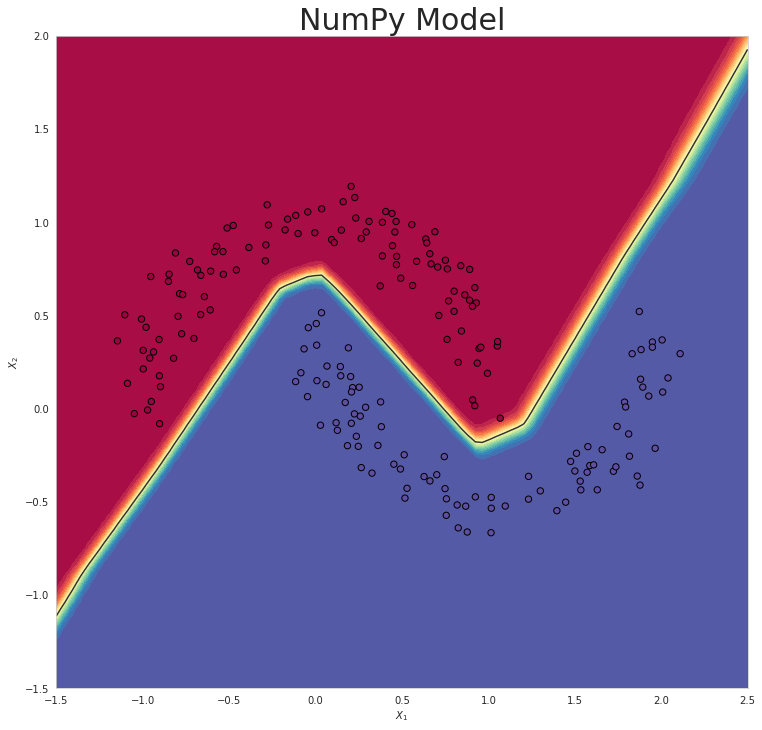

In [ ]:
def callback_numpy_plot(index, params):
    plot_title = "NumPy Model - It: {:05}".format(index)
    file_name = "numpy_model_{:05}.png".format(index//50)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    prediction_probs, _ = full_forward_propagation(np.transpose(grid_2d), params, NN_ARCHITECTURE)
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_test, y_test, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs, dark=True)

# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 5000, 0.05)

prediction_probs_numpy, _ = full_forward_propagation(np.transpose(grid_2d), params_values, NN_ARCHITECTURE)
prediction_probs_numpy = prediction_probs_numpy.reshape(prediction_probs_numpy.shape[1], 1)
make_plot(X_test, y_test, "NumPy Model", file_name=None, XX=XX, YY=YY, preds=prediction_probs_numpy)

In [ ]:
test_acc_hist = []

# Model 1
model = Sequential()
model.add(Dense(5, input_dim=2,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, verbose=0)
Y_test_hat = model.predict_classes(X_test)
acc_test = accuracy_score(y_test, Y_test_hat)
print("Test set accuracy: {:.2f} - Model 1".format(acc_test))
test_acc_hist.append(acc_test)

# Model 2
model = Sequential()
model.add(Dense(10, input_dim=2,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, verbose=0)
Y_test_hat = model.predict_classes(X_test)
acc_test = accuracy_score(y_test, Y_test_hat)
print("Test set accuracy: {:.2f} - Model 2".format(acc_test))
test_acc_hist.append(acc_test)

# Model 3
model = Sequential()
model.add(Dense(15, input_dim=2,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, verbose=0)
Y_test_hat = model.predict_classes(X_test)
acc_test = accuracy_score(y_test, Y_test_hat)
print("Test set accuracy: {:.2f} - Model 3".format(acc_test))
test_acc_hist.append(acc_test)

# Model 4
model = Sequential()
model.add(Dense(20, input_dim=2,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, verbose=0)
Y_test_hat = model.predict_classes(X_test)
acc_test = accuracy_score(y_test, Y_test_hat)
print("Test set accuracy: {:.2f} - Model 4".format(acc_test))
test_acc_hist.append(acc_test)

# Model 5
model = Sequential()
model.add(Dense(25, input_dim=2,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, verbose=0)
Y_test_hat = model.predict_classes(X_test)
acc_test = accuracy_score(y_test, Y_test_hat)
print("Test set accuracy: {:.2f} - Model 5".format(acc_test))
test_acc_hist.append(acc_test)

# Model 6
model = Sequential()
model.add(Dense(30, input_dim=2,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, verbose=0)
Y_test_hat = model.predict_classes(X_test)
acc_test = accuracy_score(y_test, Y_test_hat)
print("Test set accuracy: {:.2f} - Model 6".format(acc_test))
test_acc_hist.append(acc_test)

Test set accuracy: 0.89 - Model 1
Test set accuracy: 0.91 - Model 2
Test set accuracy: 0.92 - Model 3
Test set accuracy: 0.92 - Model 4
Test set accuracy: 0.92 - Model 5
Test set accuracy: 0.91 - Model 6


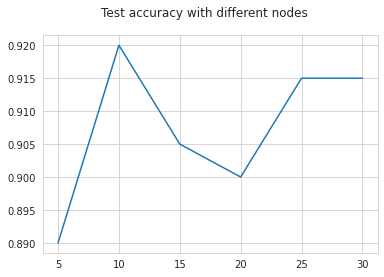

In [ ]:
plt.plot([5,10,15,20,25,30], test_acc_hist)
plt.suptitle('Test accuracy with different nodes')
plt.show()